 # Kaggle Speech Recognition 
 
 ## Step1 : Preprocessing the data

In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import random
import librosa
import librosa.display
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

lb = LabelBinarizer()
feats_mean = 0.0
feats_std = 1.0
def get_data(path):
    '''create a dataframe of file path and its corresponding word'''
    datadir = Path(path)
    file_paths_and_word = [(str(file_path), file_path.parts[-2]) for file_path in datadir.glob('**/*.wav')]
    df = pd.DataFrame(file_paths_and_word, columns=['path', 'word'])
    return df

def relabel_data(df):
    train_words = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
    words = df.word.unique().tolist()
    silence = ['_background_noise_']
    unknown = [w for w in words if w not in silence + train_words]

    df.loc[df.word.isin(silence), 'word'] = 'silence'
    df.loc[df.word.isin(unknown), 'word'] = 'unknown'
    return df

def randomly_drop_unknowns(df, drop_rate=0):
    random.seed(1.0)
    selected_rows = []
    
    for index, row in df.iterrows():
        if row.word == 'unknown':
            if random.random() < drop_rate:
                selected_rows.append(index)
    df = df.drop(df.index[selected_rows])
    return df

def get_known_labelled_data(df):
    train_words = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence']
    df.loc[df.word.isin(train_words), 'word'] = 'known'
    df = df[df.word != 'unknown']
    return df

def get_unknown_labelled_data(df):
    df = df[df.word == 'unknown']
    return df
    
def split_set(X, y, valid=0.2):
        Xt, yt, Xv, yv = [], [], [], []
        for idx, filename in enumerate(X): 
            user_id = filename[-21:-13]
            random.seed(user_id)
            if random.random() < valid:
                Xv.append(X[idx])
                yv.append(y[idx])
            else:
                Xt.append(X[idx])
                yt.append(y[idx])

        assert len(X) == len(Xt) + len(Xv)        
        return Xt, yt, Xv, yv

def split_set_gen(X, valid=0.2):
    train_file_paths_and_word, val_file_paths_and_word = [], []
    for idx, filename in enumerate(X.path): 
        user_id = filename[-21:-13]
        random.seed(user_id)
        if random.random() < valid:
            val_file_paths_and_word.append((X.path[idx], X.word[idx]))
        else:
            train_file_paths_and_word.append((X.path[idx], X.word[idx]))

    df_train = pd.DataFrame(train_file_paths_and_word, columns=['path', 'word'])
    df_val = pd.DataFrame(val_file_paths_and_word, columns=['path', 'word'])       
    return df_train, df_val
    
def gen_train_val_test_gen(df):
    df = df.reset_index(drop=True)
    #X = df.path
    #print(len(df.path)) #--> 64727
    #print(X[2353])
    
    weight = class_weight.compute_class_weight('balanced', np.unique(df.word), df.word)
    y = lb.fit(df.word)
    #print(y.shape)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    X_train, X_val = split_set_gen(df)

    #return pandas datatframe
    return X_train, X_val, weight
 
def gen_train_val_test(df):
    df = df.reset_index(drop=True)    
    X = df.path
    #print(len(df.path)) #--> 64727
    #print(X[2353])
    
    weight = class_weight.compute_class_weight('balanced', np.unique(df.word), df.word)
    y = lb.fit_transform(df.word)
    #print(y.shape)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    X_train, y_train, X_val, y_val = split_set(X, y)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    #return pandas datatframe
    return X_train, y_train, X_val, y_val, weight

### The following data augmentation functions are taken from Heng CherKeng ###
### url: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/discussion/46982 ###
AUDIO_NOISES=[]
AUDIO_SR = 16000
for file in ['dude_miaowing.wav',  'pink_noise.wav',   'white_noise.wav', 'doing_the_dishes.wav',
             'exercise_bike.wav',  'running_tap.wav']:
    audio_file = 'train/audio/_background_noise_/' + file
    wave = librosa.core.load(audio_file, sr=AUDIO_SR)[0]
    AUDIO_NOISES.append(wave)
    
def random_add_noise_transform(wave, noise_limit=0.1, u=0.5):

    if random.random() < u:
        num_noises = len(AUDIO_NOISES)
        noise = AUDIO_NOISES[np.random.choice(num_noises)]

        wave_length  = len(wave)
        noise_length = len(noise)
        if noise_length - wave_length > 1:
            t = np.random.randint(0, noise_length - wave_length - 1)
            noise = noise[t:t + wave_length]

            alpha = np.random.random() * noise_limit
            wave  = np.clip(alpha * noise + wave, -1, 1)

    return wave

def random_time_shift_transform(wave, shift_limit=0.2, u=0.5):
    if random.random() < u:
        wave_length  = len(wave)
        shift_limit = shift_limit*wave_length
        shift = np.random.randint(-shift_limit, shift_limit)
        t0 = -min(0, shift)
        t1 =  max(0, shift)
        wave = np.pad(wave, (t0, t1), 'constant')
        wave = wave[:-t0] if t0 else wave[t1:]

    return wave

AUDIO_LENGTH = 16000
def random_pad_transform(wave, length=AUDIO_LENGTH):

    if len(wave)<AUDIO_LENGTH:
        L = abs(len(wave)-AUDIO_LENGTH)
        start = np.random.choice(L)
        wave  = np.pad(wave, (start, L-start), 'constant')

    elif len(wave)>AUDIO_LENGTH:
        L = abs(len(wave)-AUDIO_LENGTH)
        start = np.random.choice(L)
        wave  = wave[start: start+AUDIO_LENGTH]

    return wave

def fix_pad_transform(wave, length=AUDIO_LENGTH):
    # wave = np.pad(wave, (0, max(0, AUDIO_LENGTH - len(wave))), 'constant')
    # return wave

    if len(wave)<AUDIO_LENGTH:
        L = abs(len(wave)-AUDIO_LENGTH)
        start = L//2
        wave  = np.pad(wave, (start, L-start), 'constant')

    elif len(wave)>AUDIO_LENGTH:
        L = abs(len(wave)-AUDIO_LENGTH)
        start = L//2
        wave  = wave[start: start+AUDIO_LENGTH]

    return wave

def train_augment(wav):
    wav = random_time_shift_transform(wav)
    wav = random_add_noise_transform(wav)
    wav = random_pad_transform(wav)
    return wav    

def val_augment(wav):
    wav = fix_pad_transform(wav)
    return wav



### The following spectrogram and mfcc related functions are taken from DavidS ###
### url: https://www.kaggle.com/davids1992/speech-representation-and-data-exploration ###
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def get_spectrogram(sample_rate, sample):
    if sample.size < 16000:
        sample = np.pad(sample, (16000 - sample.size, 0), mode='constant')
    else:
        sample = sample[0:16000]
    _, _, spectrogram = log_specgram(sample, sample_rate)
    
    return spectrogram

def print_spectrogram(spectrogram):
    plt.figure(figsize=(12, 4))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar()
    plt.show()
    
def get_mfcc(sample_rate, sample):
    if sample.size < 16000:
        sample = np.pad(sample, (16000 - sample.size, 0), mode='constant')
    else:
        sample = sample[0:16000]
    S = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    #delta2_mfcc = delta2_mfcc.reshape(13, 32, -1)
    return delta2_mfcc

def print_mfcc(mfcc):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mfcc)
    plt.ylabel('MFCC coeffs')
    plt.xlabel('Time')
    plt.title('MFCC')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

        
    
def get_mean_and_std(X, spectgram = False):
    #randomly choose 1000 samples to estimate mean and std
    idx = np.random.randint(0, len(X), 1000)
    files = X[idx]
    if spectgram:
        feats = [get_spectrogram(wavfile.read(f)[0], wavfile.read(f)[1]) for f in files]
    else:
        feats = [get_mfcc(wavfile.read(f)[0], wavfile.read(f)[1]) for f in files]
    feats = np.vstack(feats)
    feats_mean = np.mean(feats, axis=0)
    feats_std = np.std(feats, axis=0)
            
def normalize(mean, std, feature, eps=1e-14):
    return (feature - mean) / (std + eps)
    
def one_batch(X, y, spectgram = False, train=False):
    features = []
    for f in X:
        sample_rate = wavfile.read(f)[0]
        sample = wavfile.read(f)[1]
        if train:
            sample = train_augment(sample)
        else:
            sample = val_augment(sample)
            
        if spectgram:
            feats = get_spectrogram(sample_rate, sample)
            feats = normalize(feats_mean, feats_std, feats)
            features.append(feats)
        else:
            feats = get_mfcc(sample_rate, sample)
            feats = normalize(feats_mean, feats_std, feats)
            features.append(feats)
    features = np.array(features)
    labels = np.array(y)
    if spectgram:
        features = features.reshape(len(X),99,161,1)
    else:
        features = features.reshape(len(X),13,32,1)
    #print(labels.shape)
    return features, labels
    
'''   
def batch_generator(X, y, batch_size=16, spectgram = False, silence_probability=0.1, unknown_probability=0.1):
    idx_pool = range(0, X.shape[0])
    known_probability = 1-silence_probability-unknown_probability
    while True:
        features = []
        # choose batch_size random images / labels from the data 
        if len(idx_pool) < batch_size:
            idx_pool = range(0, X.shape[0])
        idx = random.sample(set(idx_pool), batch_size)
        #delete idx from idx_pool
        idx_pool = [x for x in idx_pool if x not in idx]
        for i in idx:
            features.append(X[idx])
            labels.append(y[idx])
        features = features.reshape(batch_size,13,32,1)
        #labels = labels.reshape(batch_size,12,1)
        yield features, labels 
'''
def add_feature_and_label(features, labels, df, train, spectgram):
    for idx, file in enumerate(df.path):
        sample_rate = wavfile.read(file)[0]
        sample = wavfile.read(file)[1]
        if train:
            sample = train_augment(sample)
        else:
            sample = val_augment(sample)
            
        if spectgram:
            feats = get_spectrogram(sample_rate, sample)
            feats = normalize(feats_mean, feats_std, feats)
            features.append(feats)
            labels.append(lb.transform([df.word[idx]]))
        else:
            feats = get_mfcc(sample_rate, sample)
            feats = normalize(feats_mean, feats_std, feats)
            features.append(feats)
            label = lb.transform([df.word[idx]])
            #print(label)
            labels.append(label)
    return features, labels
    
'''
def batch_generator(df, batch_size=32, spectgram = False, silence_probability=0.1, unknown_probability=0.1, train=False):
    df = df.reset_index(drop=True)
    #known_data = pd.DataFrame(columns=['path','word'])
    #silence_data = pd.DataFrame(columns=['path','word'])
    #unknown_data = pd.DataFrame(columns=['path','word'])
    known_words = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
    known_data = df.loc[df.word.isin(known_words)]
    silence_data = df.loc[df.word == 'silence']
    unknown_data = df.loc[df.word == 'unknown']
    print(len(known_data.path))
    print(len(unknown_data.path))
    print(len(silence_data.path))
    silence_num_per_batch = int(batch_size*silence_probability)
    unknown_num_per_batch = int(batch_size*unknown_probability)
    known_num_per_batch = batch_size - silence_num_per_batch - unknown_num_per_batch
    unknown_sampling_rate = unknown_num_per_batch/len(unknown_data.path)
    known_sampling_rate = known_num_per_batch/len(known_data.path)
    silence_sampling_rate = silence_num_per_batch/len(silence_data.path)
    while True:
        features = []
        labels = []
        #print(len(unknown_data.path))
        if unknown_num_per_batch > 0:
            unknown_data = unknown_data.sample(frac=1).reset_index(drop=True)
            unknown_list = unknown_data.sample(frac=unknown_sampling_rate).reset_index(drop=True)
            unknown_list = unknown_list.iloc[0:unknown_num_per_batch]
            #features, labels = add_feature_and_label(features, labels, unknown_list, train, spectgram)
        if known_num_per_batch > 0:
            known_data = known_data.sample(frac=1).reset_index(drop=True)
            known_list = known_data.sample(frac=known_sampling_rate).reset_index(drop=True)
            known_list = known_list.iloc[0:known_num_per_batch]
            #features, labels = add_feature_and_label(features, labels, known_list, train, spectgram)
        if silence_num_per_batch > 0:
            silence_data = silence_data.sample(frac=1).reset_index(drop=True)
            silence_list = silence_data.sample(frac=silence_sampling_rate).reset_index(drop=True)
            silence_list = silence_list.iloc[0:silence_num_per_batch]
            #features, labels = add_feature_and_label(features, labels, silence_list, train, spectgram)
        
        assert(len(unknown_list.path) + len(known_list.path) + len(silence_list.path) == batch_size)
        df_final = unknown_list.append(known_list).append(silence_list)
        df_final = df_final.sample(frac=1).reset_index(drop=True)
        features, labels = add_feature_and_label(features, labels, df_final, train, spectgram)
        features = np.array(features)
        labels = np.array(labels)
        features = features.reshape(batch_size,13,32,1)
        #print(features.shape)
        #print(labels.shape)
        labels = labels.reshape(batch_size,12)
        yield features, labels
'''

def random_sampling_index(sample_list, sample_num):
    l = len(sample_list)
    idx_pool = range(0, l)
    sample_idx = random.sample(idx_pool, sample_num)
    #random.shuffle(sample_list)
    return sample_idx #, sample_list
    
    
def batch_generator_2(X, y, batch_size=32, spectgram = False, silence_probability=0.1, unknown_probability=0.1, train=False):
    #generate 3 classes: known, unknown, and silence
    known_words = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
    known_data, unknown_data, silence_data = [], [], []
    known_labels, unknown_labels, silence_labels = [], [], []
    for i in range(len(X)):
        label = lb.inverse_transform(y[i].reshape(1, -1), threshold=0.5)[0]
        if label == 'unknown':
            unknown_data.append(X[i])
            unknown_labels.append(y[i])
        elif label == 'silence':
            silence_data.append(X[i])
            silence_labels.append(y[i])
        else:
            known_data.append(X[i])
            known_labels.append(y[i])
    print(len(known_data))
    print(len(unknown_data))
    print(len(silence_data))
    
    silence_num_per_batch = int(batch_size*silence_probability)
    unknown_num_per_batch = int(batch_size*unknown_probability)
    known_num_per_batch = batch_size - silence_num_per_batch - unknown_num_per_batch
    
    
    while True:
        features = []
        labels = []
        #print(len(unknown_data.path))
        if unknown_num_per_batch > 0:
            idx_list = random_sampling_index(unknown_data, sample_num=unknown_num_per_batch)
            for i in idx_list:
                features.append(unknown_data[i])
                labels.append(unknown_labels[i])
        if known_num_per_batch > 0:
            idx_list = random_sampling_index(known_data, sample_num=known_num_per_batch)
            for i in idx_list:
                features.append(known_data[i])
                labels.append(known_labels[i])
        if silence_num_per_batch > 0:
            idx_list = random_sampling_index(silence_data, sample_num=silence_num_per_batch)
            for i in idx_list:
                features.append(silence_data[i])
                labels.append(silence_labels[i])
        
        final_features = []
        final_labels = []
        assert(len(features) == batch_size)
        #print(features[0])
        idx_list = random_sampling_index(features, sample_num=len(features))
        for i in idx_list:
            final_features.append(features[i])
            final_labels.append(labels[i])
        final_features = np.array(final_features)
        final_labels = np.array(final_labels)
        final_features = final_features.reshape(batch_size,13,32,1)
        #print(features.shape)
        #print(labels.shape)
        final_labels = final_labels.reshape(batch_size,12)
        yield final_features, final_labels
    
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [71]:
## run this cell only once. This generate the sliced 'silence' files for you
from pydub import AudioSegment
from pydub.utils import make_chunks

def get_audio_slices(file_path):
    print(file_path)
    myaudio = AudioSegment.from_file(file_path , "wav") 
    chunk_length_ms = 1000 # pydub calculates in millisec
    chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

    #Export all of the individual chunks as wav files
    for i, chunk in enumerate(chunks):
        chunk_name = "train/audio/_background_noise_/running_tap_chunk{0}.wav".format(i)
        print("exporting", chunk_name)
        chunk.export(chunk_name, format="wav")
        

In [4]:
import IPython.display as ipd
ipd.Audio('test/audio/clip_0ac9b2db3.wav')

In [14]:
# Preprocess data
df = get_data('train/audio')
df = relabel_data(df)
df = randomly_drop_unknowns(df, drop_rate=0.0)
X_train, y_train, X_val, y_val, class_weights = gen_train_val_test(df)
#X_train,  X_val, class_weights = gen_train_val_test_gen(df)
#unknown_df = get_unknown_labelled_data(relabel_data(get_data('train/audio')))
print('Number of files for training: ' + str(len(X_train)))


Number of files for training: 53436


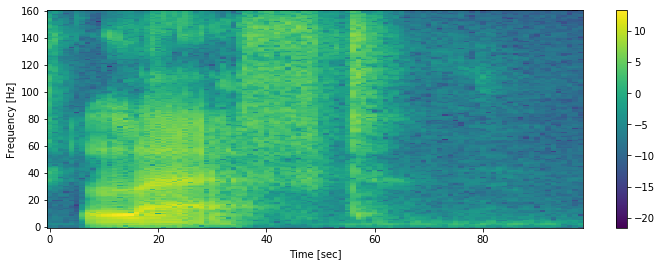

(99, 161)


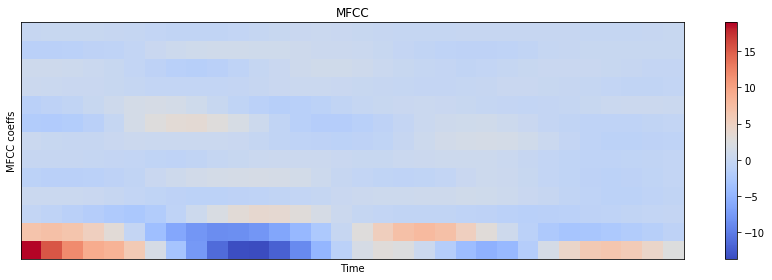

(13, 32)


In [9]:
sample_rate = wavfile.read(X_train[0])[0]
sample = wavfile.read(X_train[0])[1]
spect = get_spectrogram(sample_rate, sample)
print_spectrogram(spect)
print(spect.shape)
mfcc = get_mfcc(sample_rate, sample)
print_mfcc(mfcc)
print(mfcc.shape)

In [31]:
#compute mean and std
get_mean_and_std(X_train, spectgram = False)

#generators
#train_gen = batch_generator(X_train.values, y_train, batch_size=32)
#valid_gen = batch_generator(X_val.values, y_val, batch_size=32)

In [32]:
X_train, y_train = one_batch(X_train, y_train, spectgram = False, train=True)
X_val, y_val = one_batch(X_val, y_val, spectgram = False)
#X_unknowns, y_unknowns = one_batch(unknown_df.path, unknown_df.word)

/usr/local/lib/python3.5/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [15]:
print(X_train.shape)
print(X_val.shape)
X_train = X_train.reshape(len(X_train), 416)
X_val = X_val.reshape(len(X_val), 416)
X_unknowns = X_unknowns.reshape(len(X_unknowns), 416)
print(X_unknowns.shape)

(19527, 13, 32, 1)
(4161, 13, 32, 1)
(41039, 416)


In [33]:
import time
import os
import keras
from keras import regularizers
from keras.layers import Conv2D, Conv1D, UpSampling2D, TimeDistributed, BatchNormalization, Input, Dropout, MaxPooling2D, Dense, Flatten, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard

#GPU settings
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))

In [34]:
def get_model( output_dim=12):
    '''Create a keras model.'''
    input_data = Input(name='the_input', shape = (13, 32, 1))
    
    img = Conv2D(32, (2,2), activation='elu')(input_data)
    #img = Conv2D(32, (2,2), activation='elu')(img)
    #img = MaxPooling2D(pool_size=(2, 2))(img)
    #img = Dropout(0.25)(img)
    img = BatchNormalization()(img)
    
    img = Conv2D(64, (2,2), activation='elu')(img)
    #img = Conv2D(16, (2,2), activation='elu')(img)
    img = MaxPooling2D(pool_size=(2, 2))(img)
    img = BatchNormalization()(img)
    
    img = Conv2D(128, (2,2), activation='elu')(img)
    #img = Conv2D(16, (2,2), activation='elu')(img)
    img = MaxPooling2D(pool_size=(2, 2))(img)
    img = BatchNormalization()(img)
    
    flat = Flatten()(img)
    
    #time_dense = TimeDistributed(Dense(32, activation='elu'))(bn2)
    dense = Dense(32, activation='elu')(flat)
    dense = Dropout(0.25)(dense)
    #dense = BatchNormalization()(dense)
    
    dense = Dense(output_dim)(dense)
    y_pred = Activation('softmax', name='softmax')(dense)
    
    model = Model(inputs=input_data, outputs=y_pred) 
    return model

def get_model_2( output_dim=12):
    '''Create a keras model.'''
    input_data = Input(name='the_input', shape = (13, 32, 1))
    
    img = Conv2D(64, (3,3), activation='relu')(input_data)
    img = MaxPooling2D(pool_size=(2, 2))(img)
    img = Conv2D(64, (3,3), activation='relu')(img)
    img = MaxPooling2D(pool_size=(2, 2))(img)

    flat = Flatten()(img)
    
    #time_dense = TimeDistributed(Dense(32, activation='elu'))(bn2)
    #dense = Dense(180, activation='relu')(flat)
    #dense = Dropout(0.5)(dense)
    #dense = Dense(100, activation='relu')(dense)
    dense = Dropout(0.5)(flat)
    dense = Dense(output_dim)(dense)
    y_pred = Activation('softmax', name='softmax')(dense)
    
    model = Model(inputs=input_data, outputs=y_pred) 
    return model

model = get_model()

In [37]:
from keras import optimizers
#build model
sgd = optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()
if not os.path.exists('results'):
        os.makedirs('results')
checkpointer = ModelCheckpoint(filepath='results/'+'model_3.h5', verbose=0)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 13, 32, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 31, 32)        160       
_________________________________________________________________
batch_normalization_11 (Batc (None, 12, 31, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 30, 64)        8256      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 15, 64)         0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 5, 15, 64)         256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 14, 128)        32896     
__________

In [39]:
model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_val, y_val),
                    class_weight = class_weights,
                    verbose=1,
                    callbacks=[checkpointer])

Train on 21641 samples, validate on 4566 samples
Epoch 1/15
21641/21641 [==============================] - 4s - loss: 1.8147 - acc: 0.3860 - val_loss: 1.2821 - val_acc: 0.6170
Epoch 2/15
21641/21641 [==============================] - 4s - loss: 1.3032 - acc: 0.5599 - val_loss: 0.9578 - val_acc: 0.7092
Epoch 3/15
21641/21641 [==============================] - 4s - loss: 1.1020 - acc: 0.6347 - val_loss: 0.8127 - val_acc: 0.7407
Epoch 4/15
21641/21641 [==============================] - 4s - loss: 0.9947 - acc: 0.6748 - val_loss: 0.7352 - val_acc: 0.7716
Epoch 5/15
21641/21641 [==============================] - 4s - loss: 0.9225 - acc: 0.7033 - val_loss: 0.6842 - val_acc: 0.7852
Epoch 6/15
21641/21641 [==============================] - 4s - loss: 0.8761 - acc: 0.7217 - val_loss: 0.6842 - val_acc: 0.7799
Epoch 7/15
21641/21641 [==============================] - 4s - loss: 0.8373 - acc: 0.7341 - val_loss: 0.6246 - val_acc: 0.8042
Epoch 8/15
21641/21641 [==============================] - 4s -

In [39]:
#train model
#checkpointer = ModelCheckpoint(filepath='results/'+'model_1.h5', verbose=0)
#model = keras.models.load_model('results/'+'model_1.h5')
model.fit_generator(
    generator=batch_generator_2(X_train, y_train, batch_size=32),
    epochs=15,
    steps_per_epoch=X_train.shape[0] // 32,
    validation_data=batch_generator_2(X_val, y_val, batch_size=32),
    validation_steps=X_val.shape[0] // 32, 
    class_weight = class_weights,
    callbacks=[checkpointer])

Epoch 1/15
19522
33517
397
1666/1669 [============================>.] - ETA: 0s - loss: 0.4883 - acc: 0.83244160
7522
11
1669/1669 [==============================] - 19s - loss: 0.4884 - acc: 0.8323 - val_loss: 0.6613 - val_acc: 0.8311
Epoch 2/15
1669/1669 [==============================] - 19s - loss: 0.4718 - acc: 0.8393 - val_loss: 0.6256 - val_acc: 0.8314
Epoch 3/15
1669/1669 [==============================] - 19s - loss: 0.4553 - acc: 0.8439 - val_loss: 0.6079 - val_acc: 0.8351
Epoch 4/15
1669/1669 [==============================] - 18s - loss: 0.4417 - acc: 0.8496 - val_loss: 0.7183 - val_acc: 0.8310
Epoch 5/15
1669/1669 [==============================] - 19s - loss: 0.4237 - acc: 0.8543 - val_loss: 0.7360 - val_acc: 0.8144
Epoch 6/15
1669/1669 [==============================] - 19s - loss: 0.4151 - acc: 0.8578 - val_loss: 0.7827 - val_acc: 0.8234
Epoch 7/15
1669/1669 [==============================] - 18s - loss: 0.3948 - acc: 0.8655 - val_loss: 0.6806 - val_acc: 0.8350
Epoch 8/

In [134]:
model.save('results/'+'model_3.h5')

In [9]:
#If there are test data generated from the initial training data, run the following three cells
#convert test data into normalised spectrograms
normalized_specs = []
test_len = X_test.shape[0]
for f in X_test.values:
    normalized_specs.append(normalize(feats_mean, feats_std, get_mfcc(f)))


/usr/local/lib/python3.5/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [54]:
#make predictions
predictions = []
for i in range(100):
    pred = model.predict(np.array(normalized_specs[i].reshape(1,13,32,1)))
    predictions.extend(pred)
[lb.inverse_transform(p.reshape(1, -1), threshold=0.5)[0] for p in predictions]

NameError: name 'normalized_specs' is not defined

In [36]:
#evaluate testing result
model.evaluate(np.array(normalized_specs).reshape(test_len,13,32,1), np.array(y_test), verbose=1, batch_size = test_len)

12946/12946 [==============================] - 1s


[0.34745356440544128, 0.8902360200881958]

In [16]:
#Get data for submission
predictions = []
test = get_data('test/audio')
print(test.shape[0])
print(test.path.values[0])

158538
test/audio/clip_bd6d0fb25.wav


In [ ]:
#Generate predictions
i=0
for f in test.path.values:
    sample_rate = wavfile.read(f)[0]
    sample = wavfile.read(f)[1]
    normalized_spec = normalize(feats_mean, feats_std, get_mfcc(sample_rate, sample))
    pred = model.predict(np.array(normalized_spec.reshape(1,13,32,1)))
    predictions.extend(pred)
    i = i+1

In [18]:
labels = [lb.inverse_transform(p.reshape(1, -1), threshold=0.5)[0] for p in predictions]
test['labels'] = labels
test.path = test.path.apply(lambda x: str(x).split('/')[-1])
submission = pd.DataFrame({'fname': test.path.tolist(), 'label': labels})
submission.to_csv('submission1.csv', index=False)

In [141]:
print(labels.count('unknown'))

50295


In [142]:
print(labels.count('silence'))

14199
